<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration5_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가위바위보 분류기를 만들자!


In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt

## 1. 데이터 준비하기
우선 가위바위보 이미지를 불러와서 224x224인 이미지를 28x28로 변환해 주겠습니다.

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/scissor"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.


In [3]:
image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/rock"
resize_images(image_dir_path)
image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


다음으로 모든 이미지를 불러와서 훈련 데이터로 지정하고 정답지를 생성해 주겠습니다.
가위는 0, 바위는 1, 보는 2 입니다.

In [4]:
def load_data(img_path, number_of_data=300, img_size=28):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


불러온 이미지를 확인해 보면 아래와 같습니다.

라벨:  0


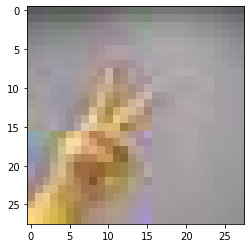

In [5]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 2. 딥러닝 네트워크 설계
이제 준비된 데이터를 학습시켜 보겠습니다. 이전 노드에서 진행했던 대로 2개의 합성곱 계층 + 맥스 풀링 계층과 하나의 어파인 계층을 사용하도록 하겠습니다.  
크기가 28x28에 3가지로 분류해야 하니 해당 값들만 바꿔주겠습니다.

In [6]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (No

In [7]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 5ms/step - loss: 8.9273 - accuracy: 0.3600
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 2.0042 - accuracy: 0.4533
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5940 - accuracy: 0.7533
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.2401 - accuracy: 0.9400
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.9833
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9833
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0377 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0054 - accuracy: 1.0000


## 3. 테스트해보기
자 이제 테스트를 해보겠습니다. 데이터는 옆자리의 주미님의 이미지를 조금 빌렸습니다.  
아까 했던 이미지 resize와 라벨링을 진행해주겠습니다.


In [8]:
resize_images('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp/scissor')
resize_images('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp/rock')
resize_images('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp/paper')

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [9]:
(x_test, y_test)=load_data('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp/')
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [10]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.1069 - accuracy: 0.5133 - 178ms/epoch - 18ms/step
test_loss: 2.10685658454895 
test_accuracy: 0.5133333206176758


34%.... 굉장히 낮네요.. 한번 파라미터를 조정해서 수정해 볼까요?

In [11]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=300
n_channel_2=100
n_dense=200
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/20
10/10 [==============================] - 0s 7ms/step - loss: 1.1041 - accuracy: 0.3833
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 1.0636 - accuracy: 0.3600
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.9828 - accuracy: 0.7767
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.8920 - accuracy: 0.5633
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.7023 - accuracy: 0.7800
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.5356 - accuracy: 0.8067
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3787 - accuracy: 0.8633
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3094 - accuracy: 0.8900
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9467
Epoch 10/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1822 - accuracy: 0.9500
Epoch 11/20
10/10 [

In [12]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.00644158 0.00938124 0.98417723]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


이건.. 전부 보로 밀었다고 봐도 될 것 같은데.. 학습이 뭔가 잘못되었나보다.

한번 60%가 넘긴 했는데 이게 돌릴 때마다 랜덤하게 나온다.. 흠.. 사진을 그레이화해서 한번 테스트 해보려고 한다.

In [13]:
def load_data_gray(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=1
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file).convert('L'),dtype=np.int32)
        imgs[idx,:,:,:]=img.reshape(28, 28, 1)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file).convert('L'),dtype=np.int32)
        imgs[idx,:,:,:]=img.reshape(28, 28, 1)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file).convert('L'),dtype=np.int32)
        imgs[idx,:,:,:]=img.reshape(28, 28, 1)    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [14]:
x_train_gray, y_train_gray = load_data_gray('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper')
x_test_gray, y_test_gray = load_data_gray('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp')

학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.


In [15]:
x_train_gray_norm = x_train_gray/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_gray_norm = x_test_gray/255.0   # 입력은 0~1 사이의 값으로 정규화

In [16]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=1024
n_channel_2=2048
n_dense=512
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_gray_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_gray_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/20
10/10 [==============================] - 1s 34ms/step - loss: 1.2461 - accuracy: 0.3333
Epoch 2/20
10/10 [==============================] - 0s 26ms/step - loss: 1.0918 - accuracy: 0.4267
Epoch 3/20
10/10 [==============================] - 0s 26ms/step - loss: 1.0720 - accuracy: 0.4400
Epoch 4/20
10/10 [==============================] - 0s 25ms/step - loss: 1.0112 - accuracy: 0.5833
Epoch 5/20
10/10 [==============================] - 0s 24ms/step - loss: 0.8055 - accuracy: 0.7600
Epoch 6/20
10/10 [==============================] - 0s 24ms/step - loss: 0.5490 - accuracy: 0.8500
Epoch 7/20
10/10 [==============================] - 0s 24ms/step - loss: 0.3773 - accuracy: 0.8733
Epoch 8/20
10/10 [==============================] - 0s 24ms/step - loss: 0.3741 - accuracy: 0.8667
Epoch 9/20
10/10 [==============================] - 0s 24ms/step - loss: 0.2523 - accuracy: 0.9033
Epoch 10/20
10/10 [==============================] - 0s 24ms/step - loss: 0.1597 - accuracy: 0.9500
Epoch 11/

In [17]:
predicted_result = model.predict(x_test_gray_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [3.4356668e-07 2.9353530e-04 9.9970609e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


이것도 별 효과가 없다.. 여전히 보를 가장 많이 예측하고 있다.
혹시나 싶어서 원본 데이터를 학습시켜서 예측해 보았다.

In [18]:
def load_data_one(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=224
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [19]:
x_train_one, y_train = load_data_one('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/one')
x_test_one, y_test = load_data_one('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/one/jumi_rcp')

학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.


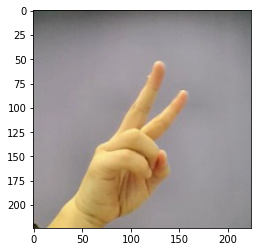

In [20]:
plt.imshow(x_train_one[0])

더욱 선명한 이 사진을 학습시키면 더 결과가 좋지 않을까?

In [21]:
x_train_one_norm = x_train_one/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_one_norm = x_test_one/255.0   # 입력은 0~1 사이의 값으로 정규화

In [22]:
n_channel_1=64
n_channel_2=128
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_one_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_one_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
10/10 [==============================] - 1s 64ms/step - loss: 3.4920 - accuracy: 0.3933
Epoch 2/10
10/10 [==============================] - 0s 48ms/step - loss: 1.0257 - accuracy: 0.4967
Epoch 3/10
10/10 [==============================] - 0s 47ms/step - loss: 0.8079 - accuracy: 0.7667
Epoch 4/10
10/10 [==============================] - 0s 50ms/step - loss: 0.3938 - accuracy: 0.9300
Epoch 5/10
10/10 [==============================] - 0s 48ms/step - loss: 0.1359 - accuracy: 0.9700
Epoch 6/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0429 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0227 - accuracy: 0.9933
Epoch 8/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 49ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 47ms/step - loss: 0.0016 - accuracy: 1.0000
10/10 - 0

In [23]:
predicted_result = model.predict(x_test_one_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.06882344 0.14659427 0.7845823 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


보로만 분류하던 이전 모델들보단 그래도 바위, 보를 고루 분류하도록 학습되었지만 여전히 가위를 잘 분류해내지 못한다.  
내가 찍은 사진의 배경때문에 그런건가 싶어서 사진을 잘라서 중간 부분만 사용해 보도록 하겠다.

In [24]:
def load_data_crop(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=18
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file).crop((5, 5, 23, 23)),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file).crop((5, 5, 23, 23)),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file).crop((5, 5, 23, 23)),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [25]:
x_train_crop, y_train = load_data_crop('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper')
x_test_crop, y_test = load_data_crop('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/jumi_rcp')

학습데이터(x_train)의 이미지 개수는 300 입니다.
학습데이터(x_train)의 이미지 개수는 300 입니다.


In [26]:
x_train_crop_norm = x_train_crop/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_crop_norm = x_test_crop/255.0   # 입력은 0~1 사이의 값으로 정규화

In [27]:
n_channel_1=1024
n_channel_2=128
n_dense=32
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(18,18,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_crop_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_crop_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

predicted_result = model.predict(x_test_crop_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

Epoch 1/20
10/10 [==============================] - 1s 9ms/step - loss: 1.1191 - accuracy: 0.3400
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 1.0747 - accuracy: 0.4667
Epoch 3/20
10/10 [==============================] - 0s 5ms/step - loss: 1.0220 - accuracy: 0.4867
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 0.9157 - accuracy: 0.7000
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 0.7876 - accuracy: 0.6567
Epoch 6/20
10/10 [==============================] - 0s 6ms/step - loss: 0.6387 - accuracy: 0.7433
Epoch 7/20
10/10 [==============================] - 0s 5ms/step - loss: 0.4655 - accuracy: 0.8433
Epoch 8/20
10/10 [==============================] - 0s 5ms/step - loss: 0.3595 - accuracy: 0.8767
Epoch 9/20
10/10 [==============================] - 0s 5ms/step - loss: 0.3219 - accuracy: 0.8767
Epoch 10/20
10/10 [==============================] - 0s 5ms/step - loss: 0.3246 - accuracy: 0.8967
Epoch 11/20
10/10 [

이런.. 선명한 사진을 사용하지 않으니 보 밖에 구분하지 못한다.  
결국 주변 분들에게 가위바위보 사진을 받아서 학습 데이터를 늘려보기로 결정했다.

In [28]:
def load_data_all(img_path, number_of_data=900, img_size=28):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    for file in glob.iglob(img_path+'/yesong_rcp/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
    for file in glob.iglob(img_path+'/jumi_rcp/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
    
    for file in glob.iglob(img_path+'/yesong_rcp/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
    for file in glob.iglob(img_path+'/jumi_rcp/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
    
    
    for file in glob.iglob(img_path+'/yesong_rcp/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
    for file in glob.iglob(img_path+'/jumi_rcp/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [29]:
image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper"
(x_train, y_train)=load_data_all(image_dir_path, 600)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 600 입니다.
x_train shape: (600, 28, 28, 3)
y_train shape: (600,)


In [30]:
x_test, y_test = load_data('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper', 300)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 300 입니다.


In [31]:
x_test.shape

(300, 28, 28, 3)

In [32]:
n_channel_1=400
n_channel_2=300
n_dense=256
n_train_epoch=30

model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model2.add(keras.layers.MaxPool2D(2,2))
model2.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(n_dense, activation='relu'))
model2.add(keras.layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model2.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model2.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

predicted_result = model2.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

Epoch 1/30
19/19 [==============================] - 1s 10ms/step - loss: 1.0526 - accuracy: 0.4567
Epoch 2/30
19/19 [==============================] - 0s 7ms/step - loss: 0.7086 - accuracy: 0.7233
Epoch 3/30
19/19 [==============================] - 0s 7ms/step - loss: 0.3935 - accuracy: 0.8633
Epoch 4/30
19/19 [==============================] - 0s 7ms/step - loss: 0.3056 - accuracy: 0.9033
Epoch 5/30
19/19 [==============================] - 0s 7ms/step - loss: 0.2148 - accuracy: 0.9283
Epoch 6/30
19/19 [==============================] - 0s 7ms/step - loss: 0.2258 - accuracy: 0.9117
Epoch 7/30
19/19 [==============================] - 0s 7ms/step - loss: 0.1894 - accuracy: 0.9200
Epoch 8/30
19/19 [==============================] - 0s 7ms/step - loss: 0.1817 - accuracy: 0.9417
Epoch 9/30
19/19 [==============================] - 0s 7ms/step - loss: 0.1589 - accuracy: 0.9400
Epoch 10/30
19/19 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9633
Epoch 11/30
19/19 

학습 데이터를 늘리니까 내가 원했던 60% 이상의 정확도를 보였다.  
여기에 원본 데이터를 적용하면 정확도가 더 오르지 않을까?

In [33]:
image_dir_path = "/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/one"
(x_train, y_train)=load_data_all(image_dir_path, 600, img_size=224)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_test, y_test = load_data('/content/drive/MyDrive/Colab/Datasets/rock_scissor_paper/one', 300, img_size=224)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_train)의 이미지 개수는 600 입니다.
x_train shape: (600, 224, 224, 3)
y_train shape: (600,)
학습데이터(x_train)의 이미지 개수는 300 입니다.


In [34]:
n_channel_1=400
n_channel_2=300
n_dense=256
n_train_epoch=20

model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(224,224,3)))
model2.add(keras.layers.MaxPool2D(2,2))
model2.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D((2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(n_dense, activation='relu'))
model2.add(keras.layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model2.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model2.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

predicted_result = model2.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=2  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

Epoch 1/20
19/19 [==============================] - 9s 353ms/step - loss: 6.3701 - accuracy: 0.4150
Epoch 2/20
19/19 [==============================] - 5s 271ms/step - loss: 1.0204 - accuracy: 0.5500
Epoch 3/20
19/19 [==============================] - 5s 271ms/step - loss: 0.7930 - accuracy: 0.7650
Epoch 4/20
19/19 [==============================] - 5s 271ms/step - loss: 0.4779 - accuracy: 0.8467
Epoch 5/20
19/19 [==============================] - 5s 271ms/step - loss: 0.4174 - accuracy: 0.8283
Epoch 6/20
19/19 [==============================] - 5s 271ms/step - loss: 0.3138 - accuracy: 0.8717
Epoch 7/20
19/19 [==============================] - 5s 271ms/step - loss: 0.2265 - accuracy: 0.9117
Epoch 8/20
19/19 [==============================] - 5s 271ms/step - loss: 0.1724 - accuracy: 0.9383
Epoch 9/20
19/19 [==============================] - 5s 271ms/step - loss: 0.1403 - accuracy: 0.9550
Epoch 10/20
19/19 [==============================] - 5s 270ms/step - loss: 0.1274 - accuracy: 0.9567

막상 해보니 크게 좋은 효과는 얻지 못했다. 이전과 동일한 62%정도의 결과..  
여러번 테스트해보고 싶었는데 할때마다 코랩 GPU어쩌고 하면서 팅겨서 그냥 여기까지.. 해야할 것 같다.

# 회고
1. 단순히 가위 바위 보의 모양이 다르니까 잘 학습할 수 있지 않을까 싶었는데 의외로 배경이나 손이 찍히는 각도나 조명의 차이 같은 요소들로 인해 제대로 구분을 하지 못하는 것 같았다.
2. 원본 데이터를 이용해서 하이퍼 파라미터 조정을 통해 더 좋은결과를 찾아보고 싶었는데 사진이 너무 커서인지 한번 돌리고 나면 GPU RAM이 가득차서 다음 돌릴 때 런타임이 끊겨버리는데... 이걸 어떻게 해결해야 할지 구글링을 해도 나오지가 않는다. 

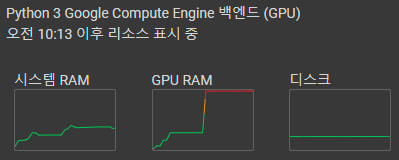  
너 왜이러니..

3. 학습할 데이터와 테스트 데이터를 다르게 고를 때마다 점수가 달라지는데 내가 찍은 사진이 배경도 비워져있고 사진에서 많은 부분을 차지하고 있었어서 이게 배경에 오버피팅되어 다른 사진을 구분하지 못하는건가 하는 생각이 들었다. (resize한 사진 중 crop 한 사진이 가장 효과가 좋았음)
4. 이미지 전처리 하는건 그냥 생각나는 대로 대충 해보았는데 구글링해보니 OpenCV를 사용하는 다양한 방법이 있었다. 다음엔 더 고급스러운 전처리를 해보도록 하자.